(-13.2, 13.2, -11.361985312699318, 15.307892571770452)

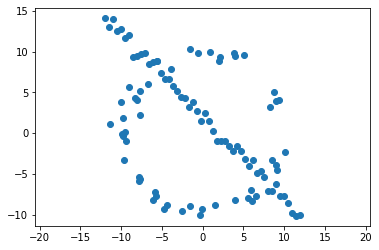

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

plt.scatter(X[:,0], X[:,1])
plt.axis('equal')

In [49]:
random_index = np.random.randint(X.shape[0], size=3)
pt1, pt2, pt3 = X[random_index]

A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
inv_A = np.linalg.pinv(A)

c_x, c_y = np.dot(inv_A, B) / 2
c_x, c_y = c_x[0], c_y[0]
r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)
print(c_x, c_y, r)

0.2731258075741786 4.327212590879088 12.11840894143381
